In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy import signal
from scipy.interpolate import interp1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
import sys
import argparse
import subprocess
import json
from sklearn.feature_extraction.image import grid_to_graph
import bigbadbrain as bbb
import dataflow as flow

In [3]:
data_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
superfly_path = os.path.join(data_dir, '20240327_superfly', 'superslices')
flies = [134,292,294]
#flies = [292]
#flies = [116,122,134,292,294,296]

true_exp_len = 1800000 #in ms. 

In [4]:
###########################
### PREP VISUAL STIMULI ###
###########################

stim_ids = []
stimulus_start_times = []
starts_angle_ms = {0:[],180:[]}
starts_angle = {0:[],180:[]}

for j,fly in enumerate(flies):
    vision_path = os.path.join(data_dir, F'fly_{fly}', 'func_0', 'visual')

    ### Load Photodiode ###
    t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
    print(len(t))
    stimulus_start_times_ = brainsss.extract_stim_times_from_pd(pd2, t)+true_exp_len*j/1000 # in sec
    if fly in [116,122]:
        stimulus_start_times_ += 0.5
    
    stimulus_start_times.extend(stimulus_start_times_)
    print(stimulus_start_times_[0])# yandan added to see whether or not the mismatch actually happened?
    print(stimulus_start_times_[-1])

    ### Get Metadata ###
    stim_ids_, angles = brainsss.get_stimulus_metadata(vision_path)
    stim_ids.extend(stim_ids_)
    print(F"Found {len(stim_ids_)} presented stimuli.")

    # *100 puts in units of 10ms, which will match fictrac
    for angle in [0,180]:
        starts_angle[angle].extend([int(sst*100) for i,sst in enumerate(stimulus_start_times_) if angles[i] == angle])
        # get 1ms version to match neural timestamps    
        starts_angle_ms[angle] = np.array(starts_angle[angle]) * 10
    print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

#     # get 1ms version to match neural timestamps
#     for angle in [0,180]:
#         starts_angle_ms[angle].extend([i*10 for i in starts_angle[angle]])

loading photodiode data... done
18000000
1.3092
1772.8593
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374
loading photodiode data... done
18000000
1800.0522
3534.4743
Loaded from Pickle.
Found 749 presented stimuli.
starts_angle_0: 622. starts_angle_180: 622
loading photodiode data... done
18000000
3600.4763
5342.9983
Loaded from Pickle.
Found 749 presented stimuli.
starts_angle_0: 870. starts_angle_180: 870


In [54]:
len(starts_angle[180])

870

In [9]:
starts_angle_ms[180][3]

74840

In [5]:
####################
### Prep Fictrac ###
####################

fps = 100
resolution = 10 #desired resolution in ms
behaviors = ['dRotLabY', 'dRotLabZ']
shorts = ['Y','Z']
fictrac = {'Y':[],'Z':[]}

for fly in flies:
    fictrac_path = os.path.join(data_dir, F'fly_{fly}', 'func_0', 'fictrac')
    fictrac_raw = brainsss.load_fictrac(fictrac_path)
    expt_len = fictrac_raw.shape[0]/fps*1000
    for behavior,short in zip(behaviors,shorts):
        fictrac_smo = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
        fictrac[short].extend(fictrac_smo[:true_exp_len])
fictrac_timestamps = np.arange(0,true_exp_len*len(flies),resolution)

In [11]:
fictrac_timestamps

array([      0,      10,      20, ..., 5399970, 5399980, 5399990])

In [6]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 400

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)

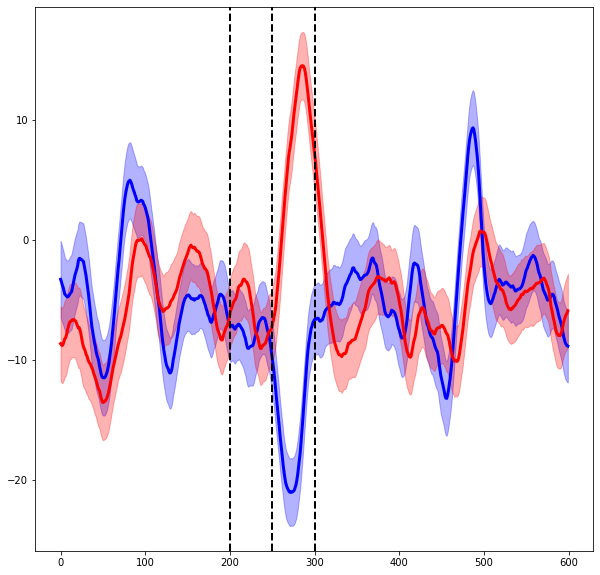

In [8]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [9]:
stim_start = 250
stim_stop = 300
av_thresh = 50

mean_turn = (mean_trace[0] + mean_trace[180]*-1)/2

ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                      mean_turn = mean_turn,
                                                                      start=stim_start, 
                                                                      stop=stim_stop, 
                                                                      r_thresh=.2, 
                                                                      av_thresh=av_thresh, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)
#### 0.2 in what unit ###

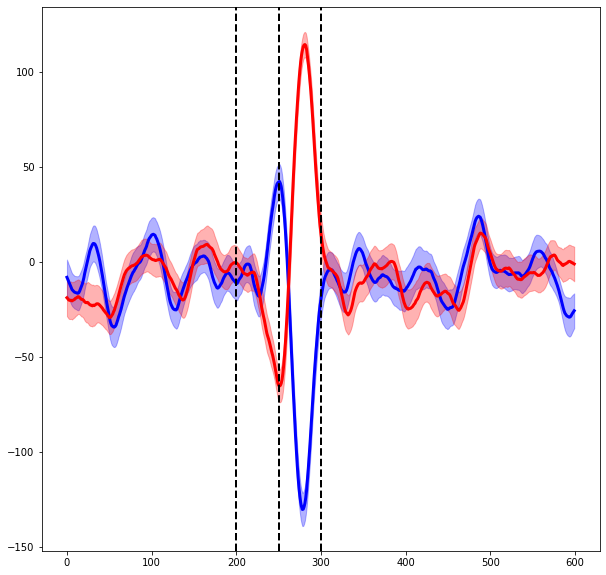

In [10]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [11]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [12]:
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
                                  start=250,
                                  stop=300,
                                  num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
                                  stim_times=starts_angle_ms[angle])

(-50.0, 50.0)

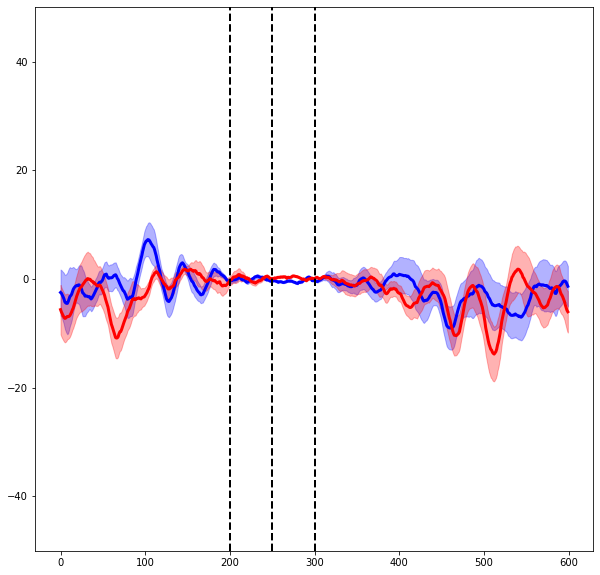

In [13]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

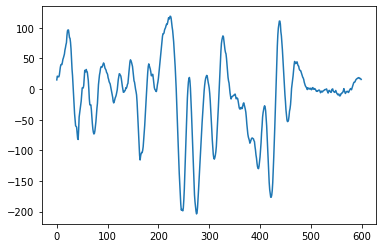

In [19]:
plt.plot(ve_turns[0][3])

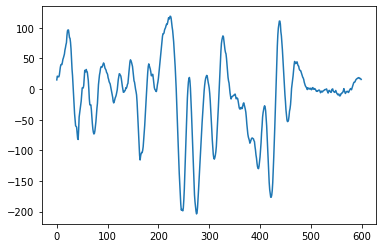

In [24]:
plt.plot(ve_turns[0][3,:])

In [27]:
len(ve_turn_times[0])

165

In [13]:
#ve_turn_times[0]

In [13]:
# Calculate the start times for moving
start_moving = [time + 500 for time in ve_turn_times[0]]  # 500ms after the static stimulus appears

# Calculate the end times for moving
end_moving = [time + 750 for time in ve_turn_times[0]]  # 500ms + 250ms after the static stimulus appears

# Now you have the start_moving and end_moving lists
# print("Start Moving Times:", start_moving)
# print("End Moving Times:", end_moving)

In [15]:
type(fictrac['Z'])

list

In [16]:
len(segments[100])

NameError: name 'segments' is not defined

In [ ]:
len(seg_means)

In [14]:
dims = {'x': 240,
        'y': 112,
        'z': 36,
        't': 3384}

In [15]:
#########################
### POST-WARP LOADING ###
#########################

n_clusters = 2000

load_file = os.path.join(superfly_path, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(superfly_path, 'cluster_signals.npy')
all_signals = np.load(load_file)

dim_z = 36

In [16]:
timestamps = np.empty((0,49))
for j,fly in enumerate(flies):
    timestamps_ = brainsss.load_timestamps(os.path.join(data_dir, F'fly_{fly}', 'func_0', 'imaging'))
    timestamps_ += true_exp_len*j
    timestamps = np.concatenate((timestamps,timestamps_),axis=0)

Trying to load timestamp data from hdf5 file.
Success.
Trying to load timestamp data from hdf5 file.
Success.
Trying to load timestamp data from hdf5 file.
Success.


In [28]:
timestamps.shape

(10152, 49)

array([1.04654892e+02, 6.36650593e+02, 1.16864629e+03, ...,
       5.39346216e+06, 5.39399416e+06, 5.39452615e+06])

In [16]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [17]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
grey_starts = [i*1000 for i in grey_starts] #s to ms
grey_stops = [i*1000 for i in grey_stops] #s to ms

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

In [18]:
for j,fly in enumerate(flies):
    print(fly)
    start = dims['t']*j
    stop = dims['t']*(j+1)
    
    slice_avgs = []
    for z in range(dim_z):
        idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
        grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
        grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
        grey_and_stopped = np.append(grey_and_stopped, False)
        # start and stop will calculate the baseline for fly=j
        slice_avgs.append(np.mean(all_signals[:,:,start:stop][z,:,grey_and_stopped[start:stop]],axis=0))#[start:stop],axis=0))
    baseline_brain = np.asarray(slice_avgs)
    all_signals[:,:,start:stop] -= baseline_brain[:,:,np.newaxis]
    baseline_brain.shape

134
292
294


In [19]:
fixed = brainsss.load_fda_meanbrain()

In [73]:
fixed.shape

(314, 146, 91)

In [77]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging"
file = os.path.join(dataset_path, 'anat_templates', 'luke.nii')
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1

In [78]:
anatomy.shape

(1024, 512, 256)

In [81]:
from matplotlib.colors import Normalize

ValueError: could not broadcast input array from shape (36,2000) into shape (36,2000,4,4)

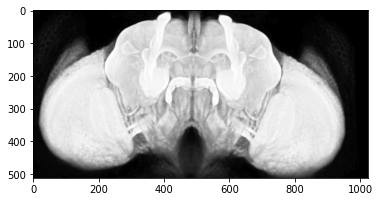

In [85]:
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(.02, .04, clip=True)(corrs)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(0.023, .064)(corrs)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

In [89]:
plt.figure(figsize=(10, 8))  # You can adjust these values as needed
plt.imshow(np.max(anatomy, axis=-1).T, cmap='gray')

# Calculate alphas from the correlations.
alphas = Normalize(.02, .04, clip=True)(corrs)
alphas = np.clip(alphas, 0, 1)  # Clip alphas to the range [0, 1].

# You need to normalize the correlations before passing them to the colormap.
normalized_corrs = Normalize(0.023, .064)(corrs)  # Adjust these values as needed for your data.
cmap = plt.cm.hot
colors = cmap(normalized_corrs)  # This should give you an MxNx4 array.

# The colors array should be in the shape MxNx4 after applying the colormap.
# Now, we set the alpha channel to the alphas we calculated.
colors[..., -1] = alphas

# Finally, we can display the colors with the alpha channel on top of the anatomical image.
plt.imshow(np.swapaxes(colors, 0, 1))
plt.axis('off')  # Hide the axes
plt.show()

In [20]:
atlas = brainsss.load_roi_atlas()

In [21]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [22]:
baseline = brainsss.STA_supervoxel_to_full_res(baseline_brain[:,np.newaxis,:], cluster_labels,
                                           dim_x=dims['x'], dim_y=dims['y'], dim_z=dims['z'])

In [23]:
baseline = baseline[:,0,:,:]
baseline = np.moveaxis(baseline,0,-1)
baseline = baseline[:,:,::-1]
baseline = ants.from_numpy(baseline)
baseline.set_spacing((2.611,2.611,5))
baseline = ants.resample_image(baseline,(314, 146, 91),use_voxels=True)

In [24]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = baseline.numpy()
vmax = 0.5
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                            roi_masks,
                                            roi_contours,
                                            data_to_plot,
                                            input_canvas,
                                            vmax=vmax,
                                            cmap='seismic',
                                            diverging=True)

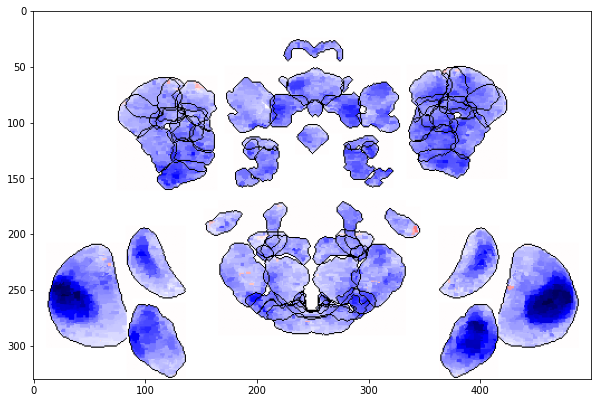

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[170:,:])

In [40]:
bin_start = -1100; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [26]:
###########################
### Create Notch Filter ###
###########################

fs = 10.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .8  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response

w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [41]:
def make_STA_brain(neural_signals, neural_timestamps, event_times_list, neural_bins):
    #### super voxel version
    
    num_z = neural_signals.shape[0]

    STA_brain = []
    for z in range(num_z):
        all_bin_indicies = []
        for stim_idx in range(len(event_times_list)):
            stim_time = event_times_list[stim_idx]
            stim_centered_bins = neural_bins + stim_time
            bin_indicies = np.digitize(neural_timestamps[:,z] , stim_centered_bins)
            all_bin_indicies.append(bin_indicies)
        all_bin_indicies = np.asarray(all_bin_indicies)

        avg_neural_across_bins = []
        for bin_num in np.arange(1,len(neural_bins)):
            this_bin_sample_times = list(np.where(all_bin_indicies==bin_num)[1])
            average_neural_in_bin = np.mean(neural_signals[z,:,this_bin_sample_times],axis=0)
            avg_neural_across_bins.append(average_neural_in_bin)
        avg_neural_across_bins = np.asarray(avg_neural_across_bins)
        STA_brain.append(avg_neural_across_bins)
    STA_brain = np.asarray(STA_brain)
    return STA_brain

In [51]:
all_signals.shape

(36, 2000, 10152)

In [27]:
# Function to find indices closest to the given time points in your timestamp array
def find_indices(timestamps, times_ms):
    indices = np.searchsorted(timestamps, times_ms, side='left')
    # Make sure we don't go out of bounds
    indices = np.clip(indices, 0, len(timestamps) - 1)
    return indices

# Calculate the start times for moving
start_moving = [time + 250 for time in ve_turn_times[0]]  # 500ms after the static stimulus appears

# Calculate the end times for moving
end_moving = [time + 1000 for time in ve_turn_times[0]]  # 500ms + 250ms after the static stimulus appears

# Assume start_moving and end_moving are defined and are in milliseconds as per your experiment timing
start_moving_ms = np.array(start_moving)
end_moving_ms = np.array(end_moving)

neuron_segments = []
for z in range(dim_z):
    z_neurons_timestamps = timestamps[:,z]
    
    # Getting indices for start and end times
    start_indices = find_indices(z_neurons_timestamps, start_moving_ms)
    end_indices = find_indices(z_neurons_timestamps, end_moving_ms)

#     print(f'start_indices: {start_indices}')
#     print(f'end_indices: {end_indices}')

    # Extract segments of neural data (z layer) based on found indices
    z_segments = np.array([np.mean(all_signals[z, :, start:end], axis=1) for start, end in zip(start_indices, end_indices)])
    neuron_segments.append(z_segments)

neuron_segments = np.array(neuron_segments).transpose(0,2,1)

neuron_segments.shape # (z, n_clusters, moving_timepoints)

(36, 2000, 165)

In [28]:
# Convert fictrac['Z'] from list to numpy array for efficient indexing
z_data = np.array(fictrac['Z'])

# Calculate the start times for moving
start_moving = [time + 500 for time in ve_turn_times[0]]  # 500ms after the static stimulus appears

# Calculate the end times for moving
end_moving = [time + 750 for time in ve_turn_times[0]]  # 500ms + 250ms after the static stimulus appears

# Assume start_moving and end_moving are defined and are in milliseconds as per your experiment timing
start_moving_ms = np.array(start_moving)
end_moving_ms = np.array(end_moving)

# Now you have the start_moving and end_moving lists
# print("Start Moving Times:", start_moving)
# print("End Moving Times:", end_moving)

# Getting indices for start and end times
start_indices = find_indices(fictrac_timestamps, start_moving_ms)
end_indices = find_indices(fictrac_timestamps, end_moving_ms)

# Extract segments of Z data based on found indices
segments = [z_data[start:end].tolist() for start, end in zip(start_indices, end_indices)]

# Now segments contains the extracted data for each interval
print("Number of segments extracted:", len(segments))
# Optional: print segments or process further as needed


Number of segments extracted: 165


In [29]:
########################
### Behavior Ephoc #####
########################

# Assuming 'segments' is already defined and each contains 25 data points
seg_means = [np.mean(segment) for segment in segments]
print(len(seg_means))

165


In [50]:
np.shape(temp.numpy())

(314, 146, 91, 24)

In [ ]:
all_signals

In [ ]:
all_warps = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    #STA_brain -= baseline_brain[:,np.newaxis,:]
    STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels, dims['x'], dims['y'], dims['z'])
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    ### upsample to (2,2,2)
    temp = STA_brain.copy()
    temp = np.moveaxis(temp,0,-1)
    temp = np.moveaxis(temp,0,-1)
    temp = ants.from_numpy(temp)
    temp.set_spacing((2.611,2.611,5,1))
    temp = ants.resample_image(temp,(314, 146, 91, len(neural_bins)-1),use_voxels=True)
    
    #t0 = time.time()
    #warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    all_warps[condition] = temp.numpy()
    #print(F'Warps {time.time()-t0}')

ve_no_0


In [31]:
neuron_segments.shape

(36, 2000, 165)

In [30]:
corrs = np.zeros(neuron_segments.shape[0:2])
pvals = np.zeros(neuron_segments.shape[0:2])

In [31]:
for i in range(neuron_segments.shape[0]):
    for j in range(neuron_segments.shape[1]):
        signals = neuron_segments[i,j,:]
        behavior = seg_means
        pearson_test = scipy.stats.pearsonr(behavior, signals)
        corrs[i,j] = pearson_test[0]
        pvals[i,j] = pearson_test[1]

In [32]:
cluster_labels.shape

(36, 26880)

In [33]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(36):
        colored_by_betas = np.zeros((256*105))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,105)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

In [ ]:
########From single fly ##########################################################
### to know how to do the explotion brain of the correlation map of superflies ###
##################################################################################
#corrs shape is (49*2000=98000)
whole_corr = np.reshape(np.asarray(corrs),(49,2000))
#(49, 2000)
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
#(49, 256, 128)
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
#(49, 1, 256, 128)
# STA_brain.shape
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_299', fixed=fixed, anat_to_mean_type='myr')
#(1, 314, 146, 91

In [57]:
corrs_reformed = supervoxel_to_full_res(corrs, cluster_labels) 

In [58]:
corr_reformed.shape

(36, 256, 128)

In [117]:
STA_brain = np.swapaxes(corrs[np.newaxis,:,:],0,1) 
STA_brain.shape

(36, 1, 2000)

In [118]:
reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels, dims['x'], dims['y'], dims['z'])
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [122]:
STA_brain.shape

(36, 1, 240, 112)

In [120]:
a = np.rollaxis(STA_brain,1,0)
a.shape

(1, 36, 240, 112)

In [123]:
temp = STA_brain.copy()

In [124]:
temp = np.moveaxis(temp,0,-1)

In [125]:
temp.shape

(1, 240, 112, 36)

In [127]:
temp = np.moveaxis(temp,0,-1)

In [128]:
temp.shape

(240, 112, 36, 1)

In [129]:
temp = ants.from_numpy(temp)

In [132]:
temp.shape
temp.set_spacing((2.611,2.611,5,1))

In [133]:
temp.shape

(240, 112, 36, 1)

In [134]:
c=temp.numpy()

In [136]:
d=np.rollaxis(c,3,0)
d.shape

(1, 240, 112, 36)

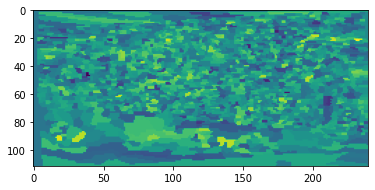

In [137]:
plt.imshow(d[0][:,:,20].T)

In [139]:
temp = ants.resample_image(temp,(314, 146, 91,1),use_voxels=True)

In [140]:
temp_np = temp.numpy()

In [45]:
#STA_brain = np.swapaxes(corrs[np.newaxis,:,:],0,1) 
### the input STA_Brain has the shape of (36, 30, 2000)
#STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
# reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels, dims['x'], dims['y'], dims['z'])
# STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    ### upsample to (2,2,2)
temp = STA_brain.copy()
temp = np.moveaxis(temp,0,-1)
temp = np.moveaxis(temp,0,-1)
temp = ants.from_numpy(temp)
temp.set_spacing((2.611,2.611,5,1))
temp = ants.resample_image(temp,(314, 146, 91, 1),use_voxels=True)
#temp = ants.resample_image(temp,(314, 146, 91, len(neural_bins)-1),use_voxels=True)
temp_np = temp.numpy()

In [90]:
corrs.shape

(36, 2000)

In [141]:
temp_np.shape

(314, 146, 91, 1)

In [142]:
temp_np_rolled=np.rollaxis(temp_np,3,0)

In [143]:
temp_np_rolled.shape

(1, 314, 146, 91)

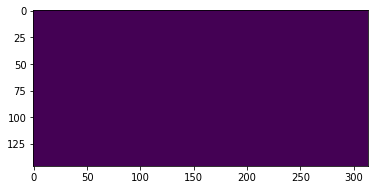

In [144]:
plt.imshow(temp_np_rolled[0][:,:,20].T)

In [121]:
input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = a[0][:,:,::-1]
vmax = .001
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')

ValueError: operands could not be broadcast together with shapes (314,146,91) (36,240,112) 

In [95]:
explosion_map.shape

(500, 500, 3)

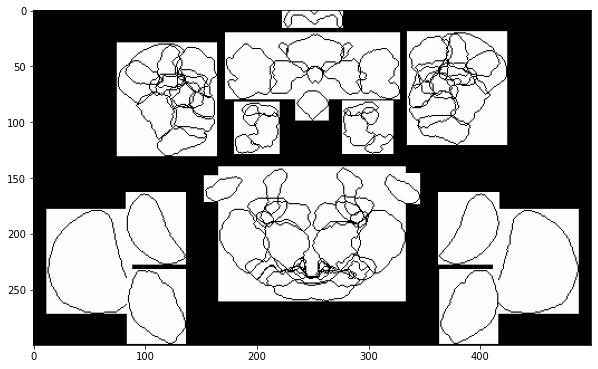

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[200:,:])

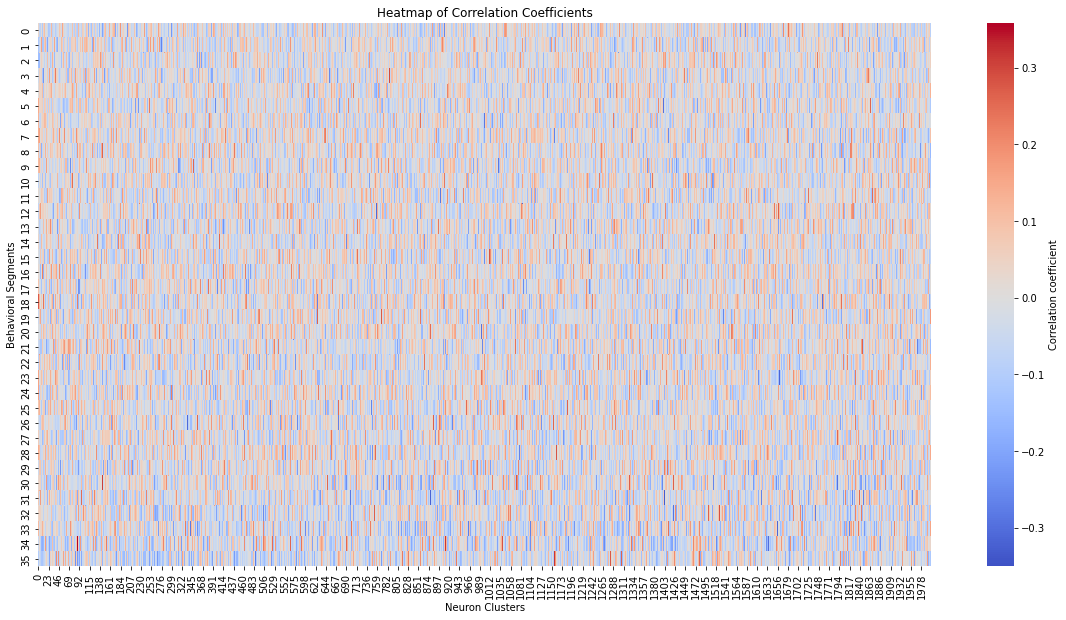

In [72]:
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.heatmap(corrs, cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Heatmap of Correlation Coefficients')
plt.xlabel('Neuron Clusters')
plt.ylabel('Behavioral Segments')
plt.show()

In [64]:
corrs[20,:]

array([ 0.06082506, -0.00630974,  0.04607967, ...,  0.02149797,
       -0.12809695, -0.07356537])

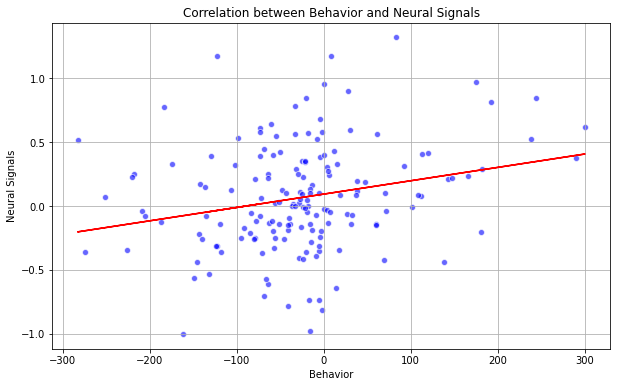

In [70]:


# Example data
z_plane_index = 18
supervoxel_index = 1800
behavior = np.array(seg_means)  # Assuming seg_means is your behavior data
signals = neuron_segments[z_plane_index, supervoxel_index, :]  # Signal data from the selected supervoxel

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(behavior, signals, alpha=0.6, edgecolors='w', color='blue')  # Scatter plot of the data
plt.title('Correlation between Behavior and Neural Signals')
plt.xlabel('Behavior')
plt.ylabel('Neural Signals')
plt.grid(True)  # Optional: add a grid for easier visualization

# Fit and plot a linear regression line
slope, intercept = np.polyfit(behavior, signals, 1)  # Fit a linear polynomial (degree 1) to the data
plt.plot(behavior, slope * behavior + intercept, color='red')  # Plot the regression line

plt.show()


In [43]:
import seaborn as sns

In [44]:
plt.figure(figsize=(20, 10))  # Adjust the size as needed
sns.heatmap(corrs[20,:], cmap='coolwarm', xticklabels=False, yticklabels=10, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap between Neural Activity and Behavior across Supervoxels')
plt.xlabel('Supervoxel Index')
plt.ylabel('Z-plane Index')
plt.colorbar()
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (2000, 1) and (2000,))

<Figure size 1440x720 with 0 Axes>

In [ ]:
#########################
### POST-WARP LOADING ###
#########################

n_clusters = 2000

load_file = os.path.join(superfly_path, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(superfly_path, 'cluster_signals.npy')
all_signals = np.load(load_file)

dim_z = 36

In [38]:
all_signals.shape

(36, 2000, 10152)

In [50]:
cluster_labels.shape

(36, 26880)

In [51]:
all_signals.shape

(36, 2000, 10152)

In [39]:
corr_reformed = supervoxel_to_full_res(corrs, cluster_labels)

In [46]:
cluster_labels.shape

(36, 26880)

In [49]:
#plt.imshow(cluster_labels[18,:])

In [ ]:
r_map = []
p_map = []
for z in range(49):
    r_map.append(np.load(rvalues_to_load[z]))
    p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))

In [110]:
n_clusters = 2000
connectivity = grid_to_graph(256,128)
model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=superfly_path,
                                linkage='ward',
                                connectivity=connectivity)
#model = model.fit(one_slice)

In [111]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

AttributeError: 'AgglomerativeClustering' object has no attribute 'labels_'

TypeError: Invalid shape (2000,) for image data

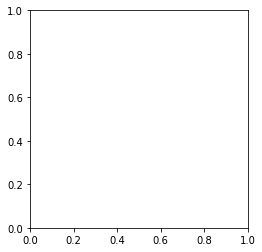

In [106]:
plt.imshow(corrs[18,:])

In [50]:
def make_STA_brain(neural_signals, neural_timestamps, event_times_list, neural_bins):
    #### super voxel version
    
    num_z = neural_signals.shape[0]

    STA_brain = []
    for z in range(num_z):
        all_bin_indicies = []
        for stim_idx in range(len(event_times_list)):
            stim_time = event_times_list[stim_idx]
            stim_centered_bins = neural_bins + stim_time
            bin_indicies = np.digitize(neural_timestamps[:,z] , stim_centered_bins)
            all_bin_indicies.append(bin_indicies)
        all_bin_indicies = np.asarray(all_bin_indicies)

        avg_neural_across_bins = []
        for bin_num in np.arange(1,len(neural_bins)):
            this_bin_sample_times = list(np.where(all_bin_indicies==bin_num)[1])
            average_neural_in_bin = np.mean(neural_signals[z,:,this_bin_sample_times],axis=0)
            avg_neural_across_bins.append(average_neural_in_bin)
        avg_neural_across_bins = np.asarray(avg_neural_across_bins)
        STA_brain.append(avg_neural_across_bins)
    STA_brain = np.asarray(STA_brain)
    return STA_brain

In [53]:
bin_start = -1100; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)
all_warps = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')
    print(STA_brain.shape)

    #STA_brain -= baseline_brain[:,np.newaxis,:]
    STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels, dims['x'], dims['y'], dims['z'])
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    ### upsample to (2,2,2)
    temp = STA_brain.copy()
    temp = np.moveaxis(temp,0,-1)
    temp = np.moveaxis(temp,0,-1)
    temp = ants.from_numpy(temp)
    temp.set_spacing((2.611,2.611,5,1))
    temp = ants.resample_image(temp,(314, 146, 91, len(neural_bins)-1),use_voxels=True)
    
    #t0 = time.time()
    #warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    all_warps[condition] = temp.numpy()
    #print(F'Warps {time.time()-t0}')

ve_no_0
STA 4.186702251434326
(36, 30, 2000)
ve_no_180
STA 4.258921146392822
(36, 30, 2000)
ve_0


KeyboardInterrupt: 